In [6]:
import realspace_tb as tb
import realspace_tb.orbitronics_2d as orb
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class ABHoneycombHamiltonian(orb.LinearFieldHamiltonian):
    def __init__(self, Lx: int, Ly: int, delta: float, field_amplitude: orb.HomogeneousFieldAmplitude) -> None:
        super().__init__(orb.HoneycombLatticeGeometry(Lx, Ly), field_amplitude)
        self.delta = delta

    def at_time(self, t: float) -> tb.backend.SparseArray:
        return super().at_time(t) + self.on_site_potential(self.delta)
    
    def on_site_potential(self, delta: float) -> tb.backend.SparseArray:
        Lx, Ly = self.geometry.Lx, self.geometry.Ly
        n = Lx * Ly
        diag = [delta if ((i // Lx + i % Lx) % 2 == 0) else -delta for i in range(n)]
        return tb.backend.sparse.diags(diag, format='csr', dtype=tb.backend.FDTYPE)

In [45]:
!pip install joblib


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# make three runs, delta = 0.0, 0.05, 0.2
# each run twice, zigzag and armchair
# for each run, save an animation and the plaquette_oam data

# params
omega = 1.0
T = 2 * np.pi / omega
T_ramp = 6 * np.pi
n_periods = 10
dt = T / 150
E_Fermi = 0.3
SAVE_ANIMATION = False
TIME_MIN = 10.0


def run_simulation(delta: float, orientation: str, save_animation: bool = True):
    if orientation == "zigzag":
        Lx, Ly = 19, 10
        field_direction = np.array([1.0, 0.0])
    elif orientation == "armchair":
        Lx, Ly = 9, 20
        field_direction = np.array([0.0, 1.0])
    else:
        raise ValueError("Orientation must be 'zigzag' or 'armchair'.")

    H = ABHoneycombHamiltonian(
        Lx,
        Ly,
        delta,
        field_amplitude=orb.RampedACFieldAmplitude(
            1e-3, omega, T_ramp=T_ramp, direction=field_direction
        ),
    )

    rho = H.ground_state_density_matrix(fermi_level=E_Fermi)

    frame_obs = orb.observables.LatticeFrameObservable(
        H.geometry,
        measurement_start_time=T_ramp,
        measurement_stride=int(T / dt / 15),
    )

    tb.RK4NeumannSolver().evolve(
        rho, H, dt, T_ramp + n_periods * T, tau=10.0, observables=[frame_obs]
    )

    if save_animation:
        orb.save_simulation_animation(
            frame_obs, f"AB_animations/{orientation}_delta_{delta}.mp4", dpi=100
        )
    return f"{orientation}_delta_{delta}", frame_obs


from joblib import Parallel, delayed

tasks = [
    (delta, orientation)
    for delta in [0, 0.05, 0.2]
    for orientation in ["zigzag", "armchair"]
]
results = Parallel(n_jobs=-1)(
    delayed(run_simulation)(delta, orientation, save_animation=SAVE_ANIMATION) for delta, orientation in tasks
)
oam_data = dict(results)

Calculating eigenvalues at t=0...
Calculating eigenvalues at t=0...
Calculating eigenvalues at t=0...
Calculating eigenvalues at t=0...
Calculating eigenvalues at t=0...
Calculating eigenvalues at t=0...


100%|██████████| 1950/1950 [00:09<00:00, 199.41it/s]


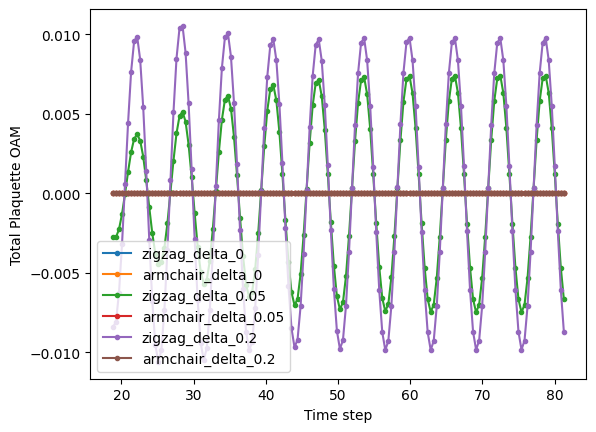

In [51]:
for key, oam in oam_data.items():
    plt.plot(oam.measurement_times, np.sum(oam.values, axis=1), ".-", label=key)

plt.xlabel("Time step")
plt.ylabel("Total Plaquette OAM")
plt.legend()
plt.show()

In [69]:
oam_data["zigzag_delta_0"].plaquette_oam_obs

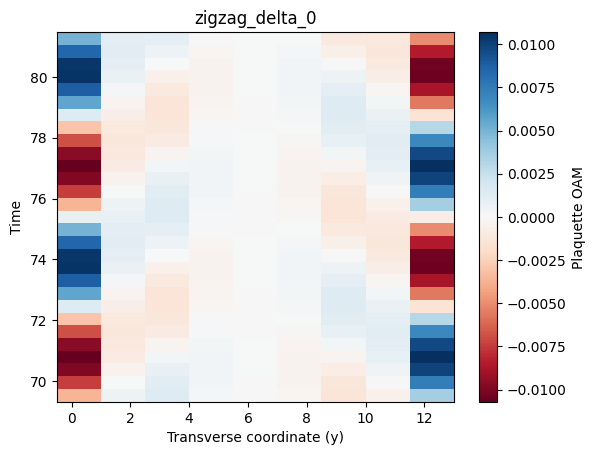

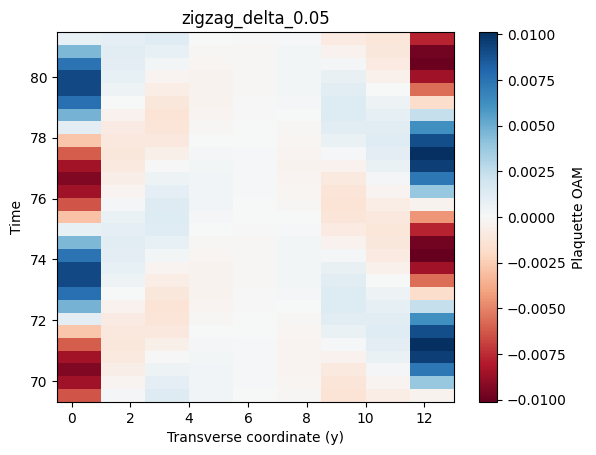

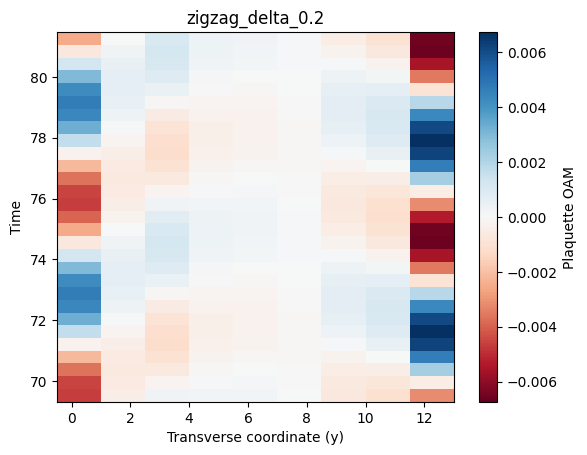

In [77]:
TIME_MIN = (n_periods - 2) * T + T_ramp
SHOW_ARMCHAIR = False

for key, oam in oam_data.items():
    orientation = key.split("_")[0]
    if orientation == "zigzag":
        geometry = orb.HoneycombLatticeGeometry(19, 10)
        transverse_axis = 1
        transverse_label = "y"
    else:
        if not SHOW_ARMCHAIR:
            continue
        geometry = orb.HoneycombLatticeGeometry(9, 20)
        transverse_axis = 0
        transverse_label = "x"

    plaquette_oam = oam.plaquette_oam_obs.values  # shape (n_times, n_plaquettes)

    plaquette_indices = oam.plaquette_anchor_indices
    plaquette_pos = geometry.index_to_position(np.asarray(plaquette_indices))
    plaquette_pos = np.asarray(plaquette_pos, dtype=float)
    if plaquette_pos.shape[0] != plaquette_oam.shape[1] and plaquette_pos.shape[1] == plaquette_oam.shape[1]:
        plaquette_pos = plaquette_pos.T

    coords = plaquette_pos[:, transverse_axis]

    rounded = np.round(coords, decimals=6)
    uniq_rounded, inverse = np.unique(rounded, return_inverse=True)
    coord_sums = np.zeros_like(uniq_rounded, dtype=float)
    counts = np.bincount(inverse)
    np.add.at(coord_sums, inverse, coords)
    coord_centers = coord_sums / np.maximum(counts, 1)

    agg = np.zeros((plaquette_oam.shape[0], uniq_rounded.size), dtype=plaquette_oam.dtype)
    for g in range(uniq_rounded.size):
        mask = inverse == g
        agg[:, g] = plaquette_oam[:, mask].sum(axis=1)

    order = np.argsort(coord_centers)
    coord_centers = coord_centers[order]
    agg = agg[:, order]

    times = np.asarray(oam.measurement_times)
    time_mask = times > TIME_MIN
    times = times[time_mask]
    agg = agg[time_mask]

    def centers_to_edges(x):
        x = np.asarray(x)
        if x.size == 1:
            dx = 1.0
            return np.array([x[0] - 0.5 * dx, x[0] + 0.5 * dx])
        edges = np.empty(x.size + 1, dtype=x.dtype)
        edges[1:-1] = 0.5 * (x[:-1] + x[1:])
        edges[0] = x[0] - 0.5 * (x[1] - x[0])
        edges[-1] = x[-1] + 0.5 * (x[-1] - x[-2])
        return edges

    t_edges = centers_to_edges(times)
    g_edges = centers_to_edges(coord_centers)

    vmax = np.max(np.abs(agg)) or 1.0
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(g_edges, t_edges, agg, cmap="RdBu", shading="auto", vmin=-vmax, vmax=vmax)
    ax.set_title(key)
    ax.set_xlabel(f"Transverse coordinate ({transverse_label})")
    ax.set_ylabel("Time")
    fig.colorbar(mesh, ax=ax, label="Plaquette OAM")
    plt.show()